Предсказание длительности поездки на такси

In [26]:
import os
import shutil

source = "/Users/ildargarifullin/Developer/work python/LinearRegression/kaggle.json"

destination_dir = os.path.expanduser("~/.kaggle")
destination = os.path.join(destination_dir, "kaggle.json")

os.makedirs(destination_dir, exist_ok=True)

shutil.copy(source, destination)

os.chmod(destination, 0o600)

print("✅ kaggle.json успешно установлен!")


✅ kaggle.json успешно установлен!


In [27]:
%pip install kaggle


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip3.13 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [28]:
!kaggle datasets list | head

ref                                                           title                                                    size  lastUpdated                 downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  -------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
ahmadrazakashif/bmw-worldwide-sales-records-20102024          BMW Worldwide Sales Records (2010–2024)                853348  2025-09-20 14:39:45.280000           9645        213  1.0              
ahmeduzaki/global-earthquake-tsunami-risk-assessment-dataset  Global Earthquake-Tsunami Risk Assessment Dataset       16151  2025-10-01 16:35:53.273000           3490        125  1.0              
jockeroika/life-style-data                                    Life Style Data                                       3995645  2025-10-14 13:50:45.303000           4756        112  0.8235294        
jaderz/hospital

In [29]:
!kaggle competitions download -c nyc-taxi-trip-duration

nyc-taxi-trip-duration.zip: Skipping, found more recently modified local copy (use --force to force download)


Распакую полученные данные

In [29]:
!unzip nyc-taxi-trip-duration.zip

Archive:  nyc-taxi-trip-duration.zip
  inflating: sample_submission.zip   
  inflating: test.zip                
  inflating: train.zip               


Работа только с train частью, тк там есть значения предсказываемой переменной

In [30]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

df = pd.read_csv('train.zip', compression='zip', header=0, sep=',', quotechar='"')

In [31]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Следует удалить столбец dropoff_datetime тк это время конца поездки, зная его и время начала поездки, можно легко вычилить время поездки

Во время предсказания время окончания поездки (dropoff_datetime) не может быть доступно

In [32]:
df = df.drop('dropoff_datetime', axis=1)

Когда у данных есть дата, появляется временная размерность. Разбиение данных на train и test становится не очевидным. Тк строить модель мы хотим по прошлым данным и работать с ней в будущем. Для train данные берем начиная с какой-то даты до некотрой заранее обусловленной и для test пойдут данные (поездки), которые произошли после этой обусловленной даты

Возможно сортировка данных по определенному столбцу, в нашем случае по дате начала поездки

In [33]:
df = df.sort_values(by='pickup_datetime')

Разбиваю данные на train и test

In [34]:
train_df, test_df = df[:10 ** 6], df[10 ** 6:]

In [36]:
len(test_df), len(train_df)

(458644, 1000000)

Распределение target переменной 

<Axes: >

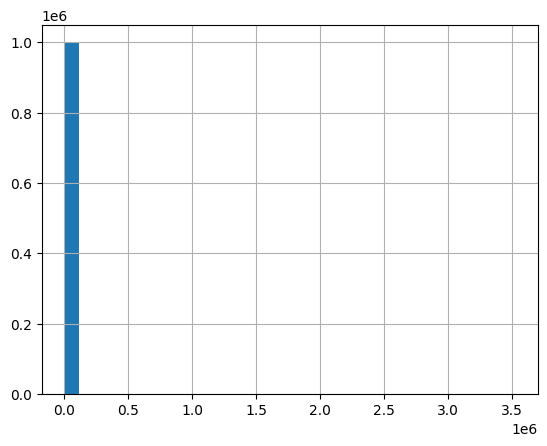

In [37]:
train_df.trip_duration.hist(bins=30)

Если данные сконцентрированы в самом начале (0) и имеют большие выбросы, то полезно посмотреть на логарифм этих данных, который может дать более подробное представление о том, как эти данные устроены

In [38]:
import numpy as np

log1p() - логариф + 1, для того чтобы увидеть данные, которые содержат 0. Например поездка завершилась сразу же (отказ от поездки и прочее). Чтобы не получить log 0 прибавляю единицу

<Axes: >

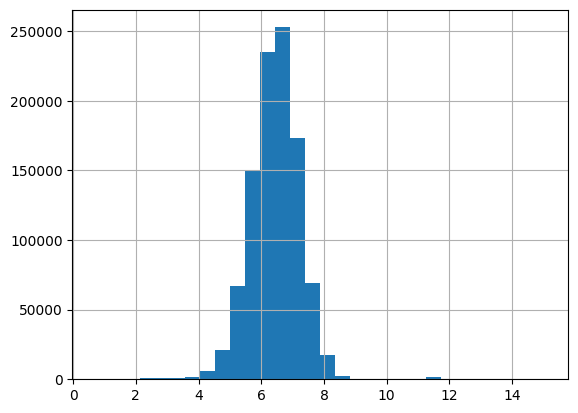

In [39]:
np.log1p(train_df.trip_duration).hist(bins=30)

Следует предсказывать не абсолютный trip_duration, а логарифм trip_duration, иногда это помогает сильно улучшить качество модели, если таргеты распределены нормально

Для этого следует обновить trip_duration, создать новый trip_duration. Обновляю и в test и в train

In [40]:
train_df['log_trip_duration'] = np.log1p(train_df.trip_duration)
test_df['log_trip_duration'] = np.log1p(test_df.trip_duration)

/var/folders/s7/zz5l021j7jq0d45kqm669ntm0000gn/T/ipykernel_12401/389882633.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['log_trip_duration'] = np.log1p(train_df.trip_duration)
/var/folders/s7/zz5l021j7jq0d45kqm669ntm0000gn/T/ipykernel_12401/389882633.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['log_trip_duration'] = np.log1p(test_df.trip_duration)


Предсказание времени поездки в зависимости от времени и местоположения 

Связь дня поездки и количества заказов в этот день

Требуется предобработка

In [41]:
train_df.pickup_datetime
test_df.pickup_datetime

627458     2016-05-04 03:16:14
1114651    2016-05-04 03:16:27
932402     2016-05-04 03:16:27
398435     2016-05-04 03:16:39
449737     2016-05-04 03:17:00
                  ...         
853710     2016-06-30 23:58:52
419031     2016-06-30 23:59:09
1008720    2016-06-30 23:59:10
405743     2016-06-30 23:59:37
500524     2016-06-30 23:59:39
Name: pickup_datetime, Length: 458644, dtype: object

Получаем строковые данные, преобразуем их в объекты

In [42]:
train_df.pickup_datetime = pd.to_datetime(train_df.pickup_datetime)
test_df.pickup_datetime = pd.to_datetime(test_df.pickup_datetime)

/var/folders/s7/zz5l021j7jq0d45kqm669ntm0000gn/T/ipykernel_12401/1515786248.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.pickup_datetime = pd.to_datetime(train_df.pickup_datetime)
/var/folders/s7/zz5l021j7jq0d45kqm669ntm0000gn/T/ipykernel_12401/1515786248.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.pickup_datetime = pd.to_datetime(test_df.pickup_datetime)


In [43]:
train_df.pickup_datetime[0]

Timestamp('2016-03-14 17:24:55')

Получу часы

In [44]:
train_df.pickup_datetime[0].hour

17

Получу день

In [45]:
train_df.pickup_datetime[0].day

14

График числа поездок по дням

Даты поездок

In [46]:
date = train_df.pickup_datetime.apply(lambda x: x.date())

Создаю специальный график с подсчетом количества поездок каждый день sns.countplot(дата поездок)

Также подпишу в какую дату была поездка

/var/folders/s7/zz5l021j7jq0d45kqm669ntm0000gn/T/ipykernel_12401/2154590775.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  date_count_plot.set_xticklabels(date_count_plot.get_xticklabels(), rotation = 90)


[Text(0, 0, '2016-01-01'),
 Text(1, 0, '2016-01-02'),
 Text(2, 0, '2016-01-03'),
 Text(3, 0, '2016-01-04'),
 Text(4, 0, '2016-01-05'),
 Text(5, 0, '2016-01-06'),
 Text(6, 0, '2016-01-07'),
 Text(7, 0, '2016-01-08'),
 Text(8, 0, '2016-01-09'),
 Text(9, 0, '2016-01-10'),
 Text(10, 0, '2016-01-11'),
 Text(11, 0, '2016-01-12'),
 Text(12, 0, '2016-01-13'),
 Text(13, 0, '2016-01-14'),
 Text(14, 0, '2016-01-15'),
 Text(15, 0, '2016-01-16'),
 Text(16, 0, '2016-01-17'),
 Text(17, 0, '2016-01-18'),
 Text(18, 0, '2016-01-19'),
 Text(19, 0, '2016-01-20'),
 Text(20, 0, '2016-01-21'),
 Text(21, 0, '2016-01-22'),
 Text(22, 0, '2016-01-23'),
 Text(23, 0, '2016-01-24'),
 Text(24, 0, '2016-01-25'),
 Text(25, 0, '2016-01-26'),
 Text(26, 0, '2016-01-27'),
 Text(27, 0, '2016-01-28'),
 Text(28, 0, '2016-01-29'),
 Text(29, 0, '2016-01-30'),
 Text(30, 0, '2016-01-31'),
 Text(31, 0, '2016-02-01'),
 Text(32, 0, '2016-02-02'),
 Text(33, 0, '2016-02-03'),
 Text(34, 0, '2016-02-04'),
 Text(35, 0, '2016-02-05'),
 T

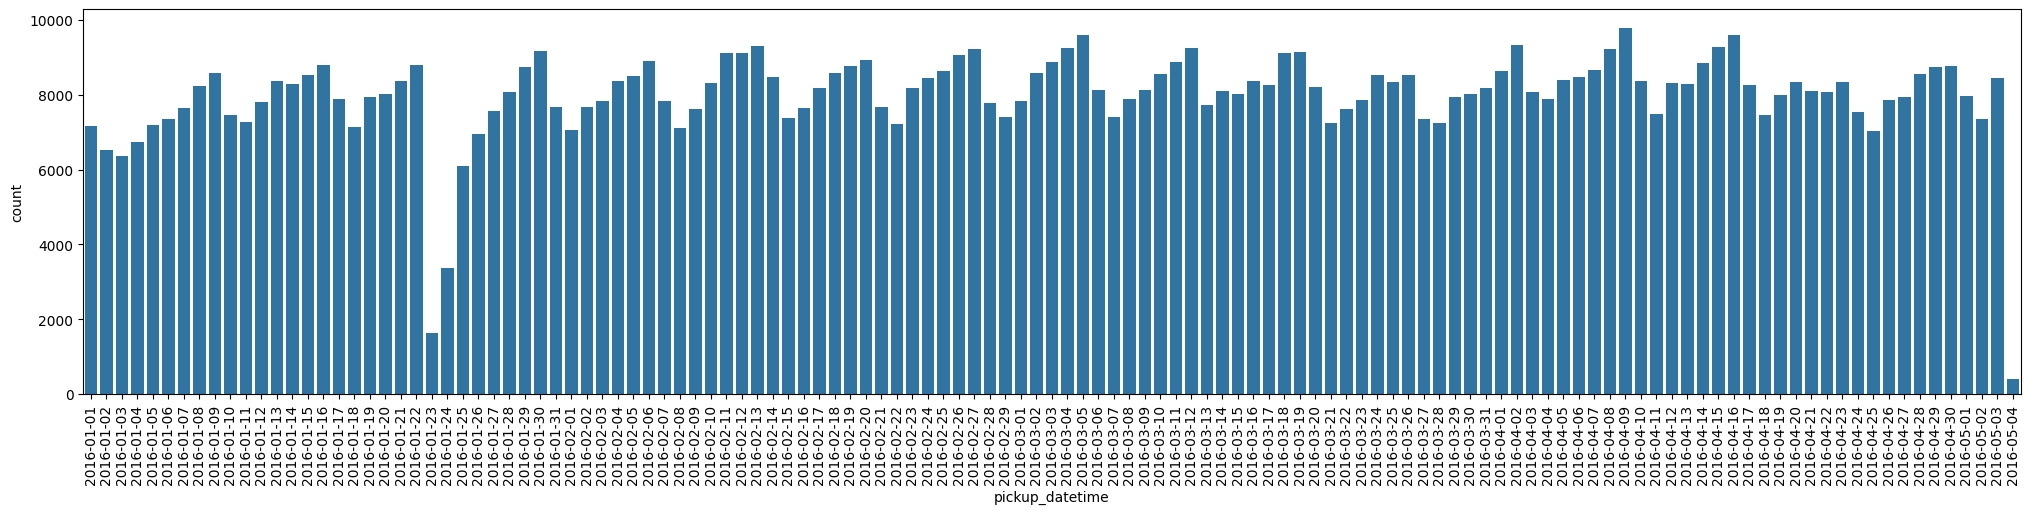

In [47]:
plt.figure(figsize=(25, 5))
date_count_plot = sns.countplot(x = date)
date_count_plot.set_xticklabels(date_count_plot.get_xticklabels(), rotation = 90)

Требуется убедиться, что переменные используемые для предсказания связаны со средней длиной поездки. В качестве признака можно использовать день. Убедимся, что в зависимости от дня меняется время поездки

Группирую данные по дате

In [48]:
grouped_train = train_df.groupby(by = date)

Создам график зависимости средней длины поездки от дня

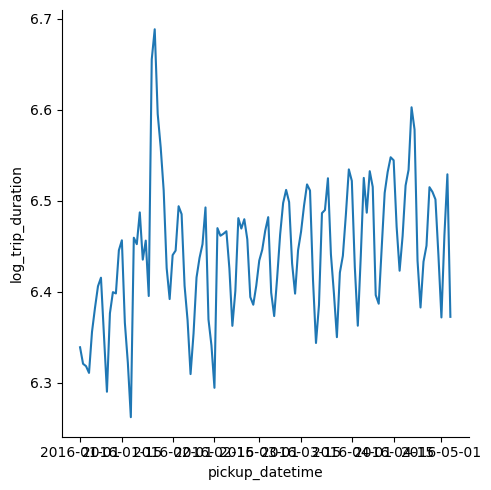

In [49]:
sns.relplot(data=grouped_train.log_trip_duration.aggregate('mean'), kind='line')

Вывод: день поездки важный признак. Наблюдается сезонность, повторяющиеся временные паттерны. Период неделя

Функция подготовки матрицы для обучения. Принимает data_frame, а возвращает матрицу для обучения и target переменную

In [50]:
import datetime

def create_features(data_frame):
    X = pd.concat([ # матрица Х, которая будет являться конкатенацией нескольких столбцов
        data_frame.pickup_datetime.apply(lambda x: x.timetuple().tm_yday),
        # признак день в году (в линейной регрессии должна быть вещественная переменная)
        # для каждого элемента pickup_datetime получу объект timetuple, .tm_yday - поле содержит номер дня в году даты с которой работаю
        data_frame.pickup_datetime.apply(lambda x: x.hour) 
        # час, когда был произведен заказ
    ], axis=1, 
    # по умолчанию конкатенация вдоль строк, мне надо вдоль столбцов axis=1
    keys=['day', 'hour']
    # называю столбцы 'day' и 'hour'
    )
    
    return X, data_frame.log_trip_duration

Обучаю на обучающей выборке

In [51]:
X_train, y_train = create_features(train_df)

In [52]:
y_train # логарифмы длины поездок

96469      6.745236
223872     7.166266
713067     6.013715
652463     5.638355
722901     6.602588
             ...   
1384418    6.735780
1100978    4.927254
630885     6.910751
567651     5.247024
777457     5.062595
Name: log_trip_duration, Length: 1000000, dtype: float64

In [53]:
X_train

,day,hour
96469,1,0
223872,1,0
713067,1,0
652463,1,0
722901,1,0
...,...,...
1384418,125,3
1100978,125,3
630885,125,3
567651,125,3


Обучение тестовой выборки

In [64]:
X_train, y_train = create_features(train_df)
X_test, y_test = create_features(test_df)

День в году это вещественный признак (в будущем не будут дни, которые были в прошлом). С часом иначе, нет понятной зависимости часа от чего либо - час это категориальный признак. Переменная час, хоть и является целым числом, не может трактоваться как вещественная. Дело в том, что после 23 идет 0, и что будет означать коэффициент регрессии в таком случае, совсем не ясно. Поэтому применим к этой переменной one -hot кодирование. В тоже время, переменная день должна остаться вещественной, так как значения из обучающей выборке не встреться нам на тестовом подмножестве

In [65]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [67]:
ohe = ColumnTransformer([("One hot", OneHotEncoder(sparse_output=False),[1])], remainder="passthrough")

In [68]:
X_train = ohe.fit_transform(X_train)
X_test = ohe.transform(X_test)

In [69]:
X_train.shape

(1000000, 25)

In [70]:
X_train

array([[  1.,   0.,   0., ...,   0.,   0.,   1.],
       [  1.,   0.,   0., ...,   0.,   0.,   1.],
       [  1.,   0.,   0., ...,   0.,   0.,   1.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0., 125.],
       [  0.,   0.,   0., ...,   0.,   0., 125.],
       [  0.,   0.,   0., ...,   0.,   0., 125.]])

0 столбец поместился в конец, а первые 24 - соответствуют часам от 0 до 23. Первый столбец - 0 час, а 24 столбец - 23 часу

Теперь в линейной регрессии будет по отдельному коэффициенту на каждый час суток

Обучение

In [71]:
from sklearn.linear_model import LinearRegression

In [72]:
lin_reg = LinearRegression()

In [73]:
lin_reg.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


Измеряю метрику

In [74]:
from sklearn.metrics import mean_squared_error

Получаем ошибку

In [76]:
mean_squared_error(y_test, lin_reg.predict(X_test))

0.6538219000582801